# Multi-Armed Bandits
*Notes from Reinforcement Learning Introduction Chapter 2*

Multi-armed bandit problems are some of the simplest reinforcement learning (RL) problems to solve. 
We have an agent which we allow to choose actions, and each action has a reward that is returned according to a given, underlying probability distribution. 
The game is played over many episodes (single actions in this case) and the goal is to maximize your reward.
An easy picture is to think of choosing between k-many one-armed bandits (i.e. slot machines) or one big slot machine with $k$ arms. 
Each arm you pull has a different reward associated with it. 
You need to develop some kind of strategy to get the most bang for your buck.
One way to approach this, is to select each one in turn and keep track of how much you received, then keep going back to the one that paid out the most. 
This is possible, but, as stated before, each bandit has an underlying probability distribution associated with it, meaning that you may need more samples before finding the right one. 
But, each pull you spend trying to figure out the best bandit to play takes you away from maximizing your reward. 
This basic balancing act is known as the explore-exploit dilemma. 
Forms of this basic problem come up in areas outside of AI and RL.

## Abstract

We introduce multi-armed bandit problems and develop a framework for solving these problems as well as examples. 
In this post, we'll focus on ϵ−greedy, ϵ−decay, and optimistic strategies.

## Problem Setup

To get started, let's describe the problem in a bit more technical detail. What we wish to do, is develop an estimate $Q_t(a)$
:
$$Q_t(a)=\mathbb{E}[R_n \mid A_n=a]$$

Where $Q_n(a)$ is the estimated, expected reward ($R_n$), when action $A_n$ is taken at step $n$. 
We're going to iteratively build a model that will converge towards the true value of each action. 
We're going to use a Gaussian (normal) distribution for all of the underlying probability distributions that we'll explore so that the mean corresponds to the true value (after all, given enough samples, we would expect our rewards to converge to the mean of the selected action).
The simplest way to proceed, is to take the greedy action or take the action we think will maximize our reward at each time step. Another way of writing this is:
$$A_n=\max_a(Q_n(a))$$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline

#Arms
from SMPyBandits.Arms import Gaussian

#Policies
#from SMPyBandits.Policies import EpsilonGreedy, EpsilonDecreasing
from mabalgs import ClassicEpsilonGreedy, ClassicEpsilonDecreasing, ClassicOptimisticGreedy

#Simulation
from SMPyBandits.Environment import MAB
from mabsim import mabs

Info: Using the Jupyter notebook version of the tqdm() decorator, tqdm_notebook() ...


There are plenty of different ways to define this class. 
I did it so that once we initialize our problem, we just call the run() method and can examine the outputs. 
By default, the average rewards for each arm are drawn from a normal distribution around 0. 
Setting $\mu$="sequence" will cause the rewards to range from $0$ to $k−1$ to make it easy to know which actions provide the best rewards when evaluating the results and which actions were taken. 

In [2]:
#figure size
plt.rcParams['figure.figsize'] = (12, 8)

#MAB parameters :

#arms
k = 10

#time-horizon
tau = 1000

#repetitions
n = 1000

In [3]:
# ALGORITHMS :

#epsilon
eps = [0, 0.01, 0.1, 0.2]

#gamblers
G = [ClassicEpsilonGreedy(k, epsilon=e) for e in eps]

## First Setting : 10 Gaussian Arms with Random Means

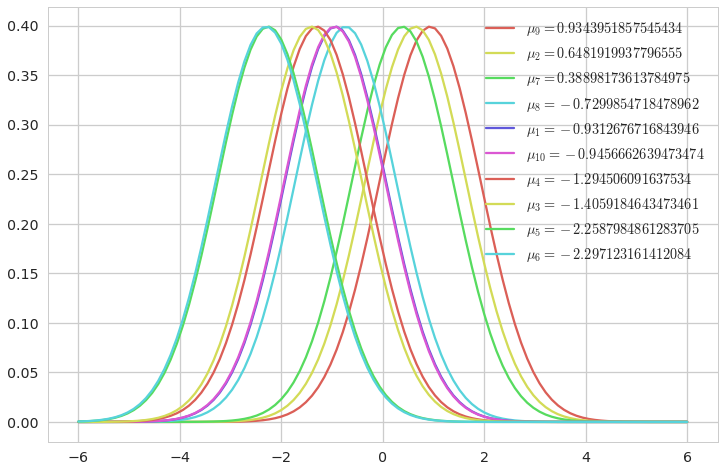

In [5]:
# ARMS :

# draw means from probability distribution
generative_mean = 0.0
generative_variance = 2.0
means = np.random.normal(generative_mean, generative_variance, k)

#variance for each distribution
sigma = 1.0

#arms objects (normal distribution, non-truncated)
A = [Gaussian(mu, sigma=sigma, mini=float('-inf'), maxi=float('inf')) for mu in means]

#show distributions
x = np.linspace(-6*sigma, +6*sigma, 100)
idx = np.argsort(means)[::-1] #order
#for i, mu in enumerate(means):
for i in idx:
    mu = means[i]
    plt.plot(x, mlab.normpdf(x, mu, sigma), label="$\mu_{" + str(i+1) + "}=" + str(mu) + "$")
plt.legend()
plt.show()

Looking at the results, the greedy function underperforms the other two consistently, with ϵ=0.01 coming in between the two and ϵ=0.1 performing the best of the three here. Below, we can see the effect is clearer using the sequence argument, and can get a feel for how often the optimal action is taken per episode because the 

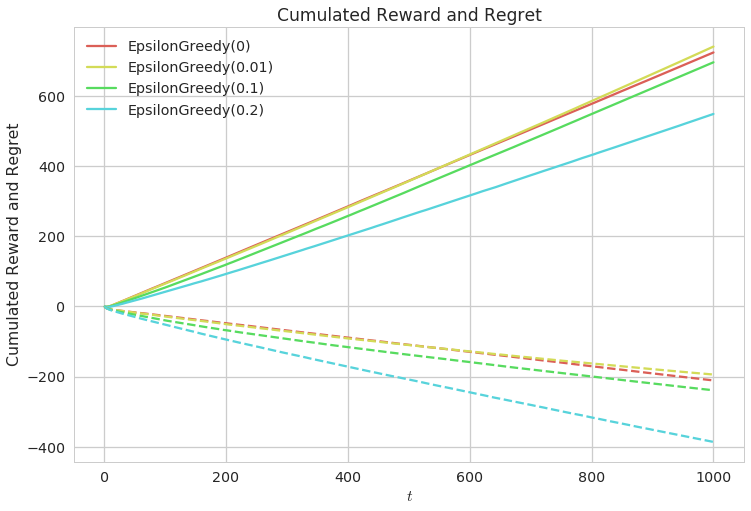

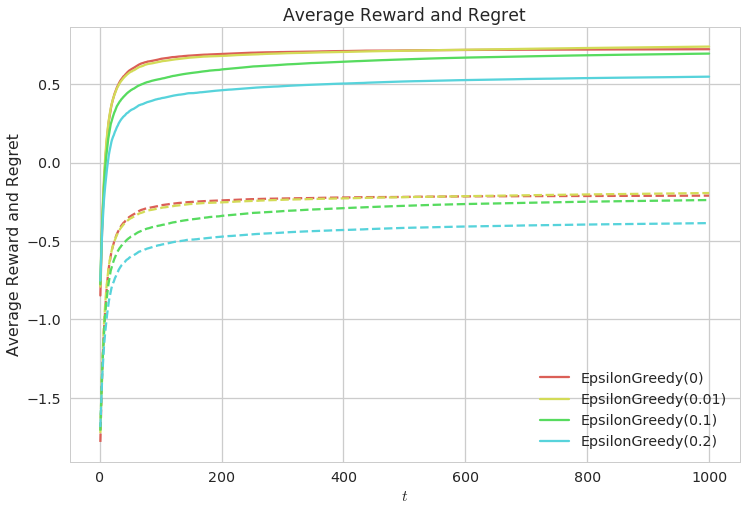

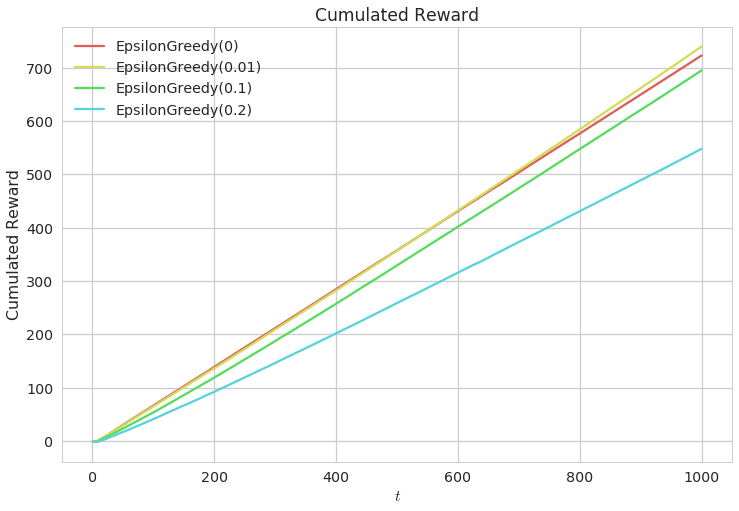

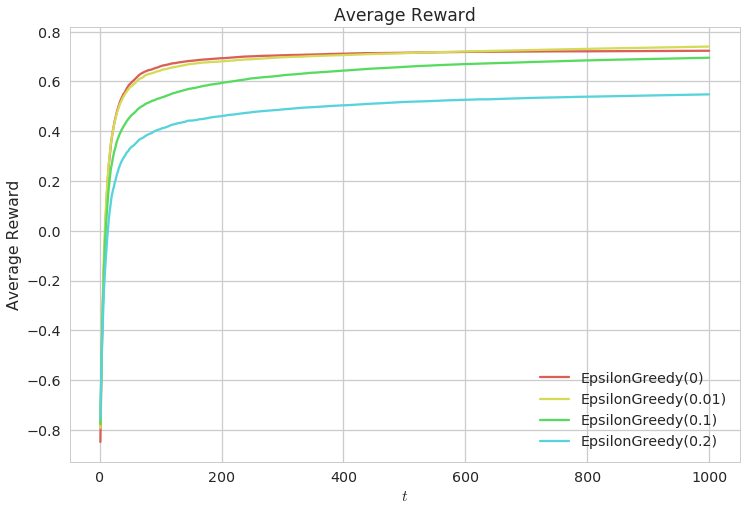

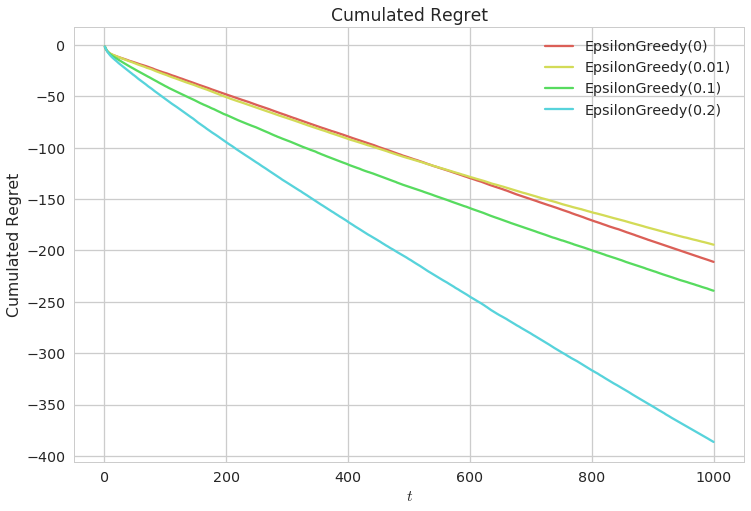

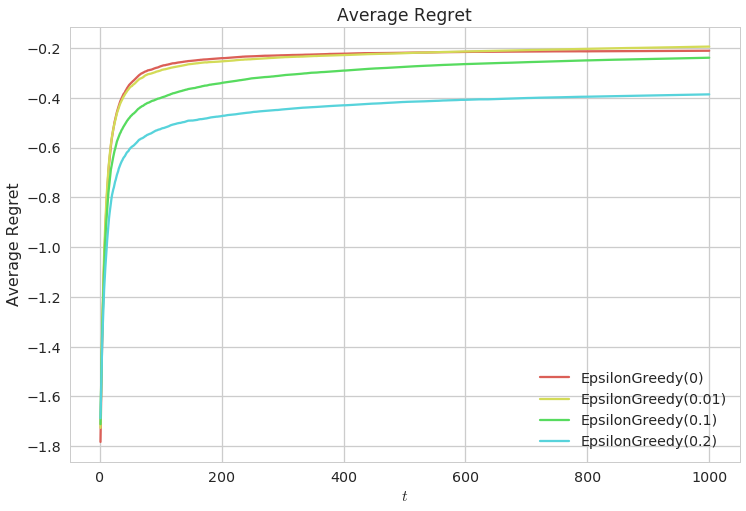

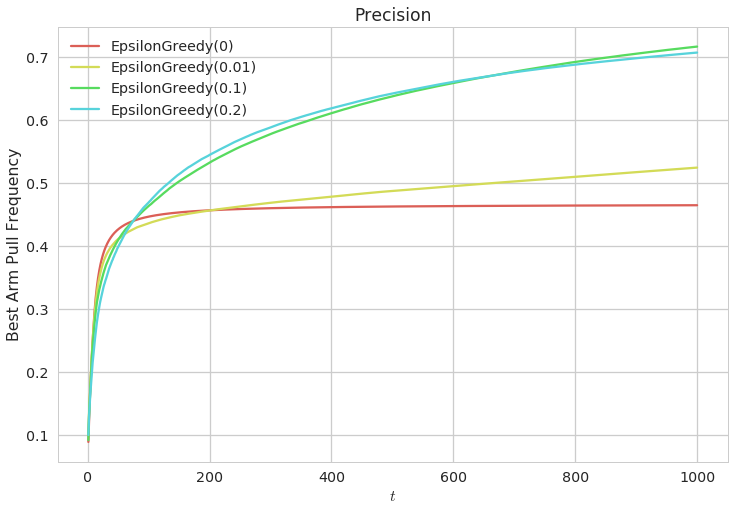

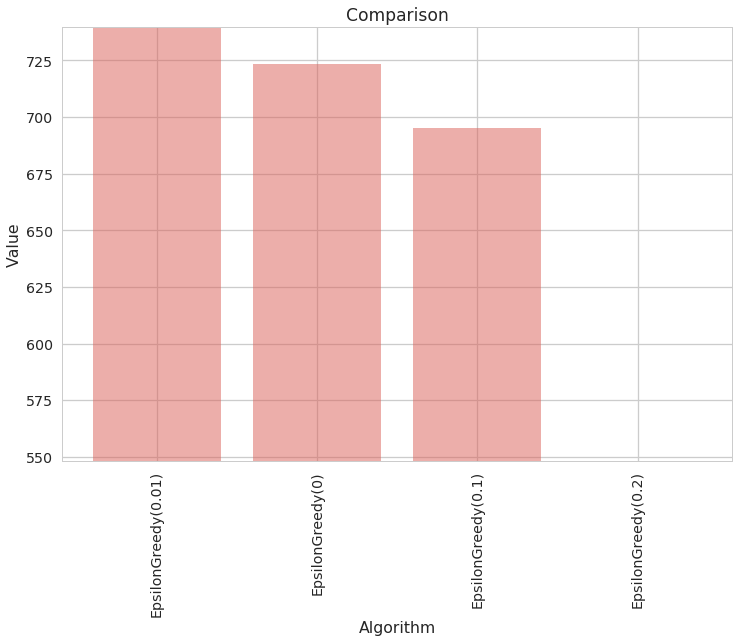

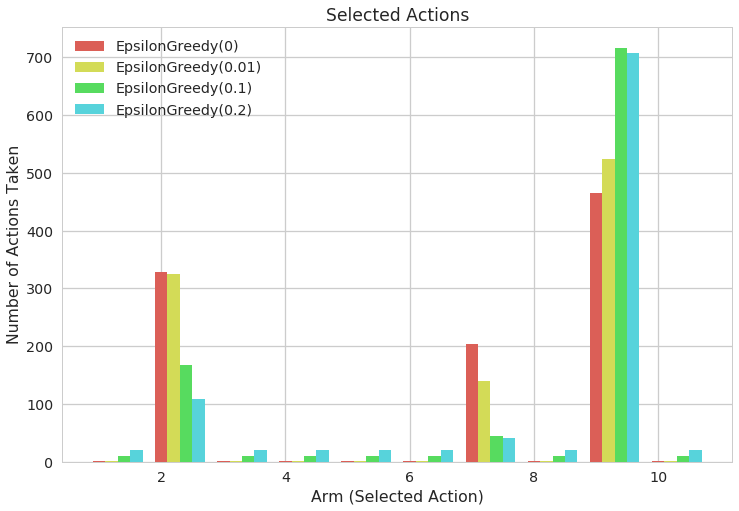

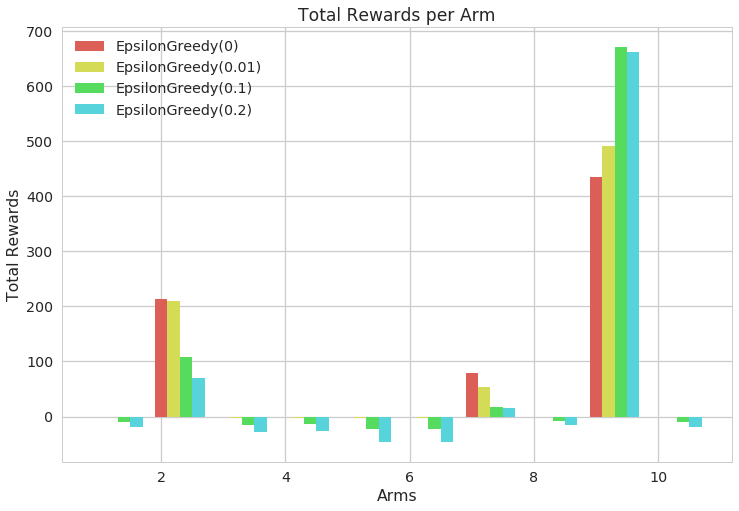

In [6]:
#Run experiments
M = mabs(A, G, tau, repetitions=n)
M.run(tqdm_leave=True)

#Plot Results
M.plot_cumulated_reward_regret_progression()
M.plot_average_reward_regret_progression()
M.plot_cumulated_reward_progression()
M.plot_average_reward_progression()
M.plot_cumulated_regret_progression()
M.plot_average_regret_progression()
M.plot_precision_progression()
M.plot_comp_algs()
M.plot_comp_arm_count()
M.plot_comp_arm_rewards()

## Second Setting : 10 Gaussian Arms with Sequential Linear Means

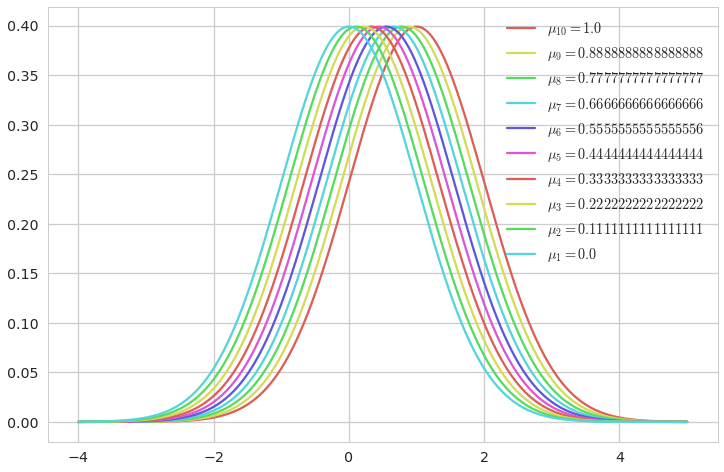

In [7]:
# ARMS :

# linear means for each arm
means = np.linspace(0, 1, k)

sigma = 1

#arms objects (normal distribution, non-truncated)
A = [Gaussian(mu, sigma=sigma, mini=float('-inf'), maxi=float('inf')) for mu in means]

#show distributions
x = np.linspace(-4*sigma, 1+4*sigma, 1000)
idx = np.argsort(means)[::-1] #order
#for i, mu in enumerate(means):
for i in idx:
    mu = means[i]
    plt.plot(x, mlab.normpdf(x, mu, sigma), label="$\mu_{" + str(i+1) + "}=" + str(mu) + "$")
plt.legend()
plt.show()

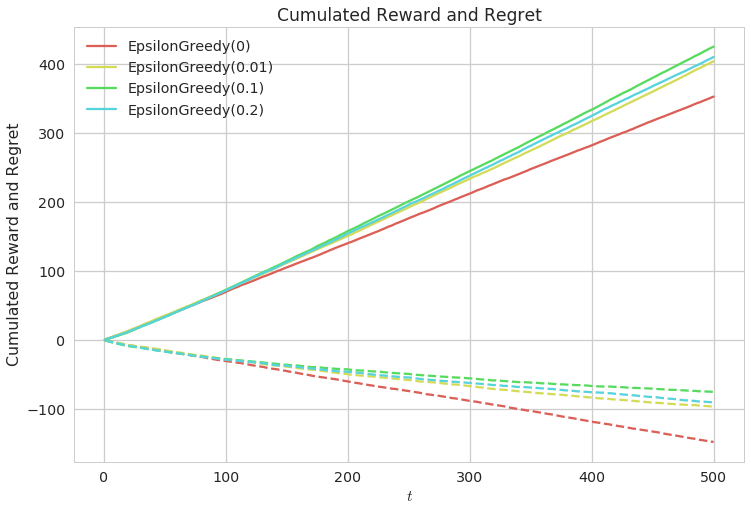

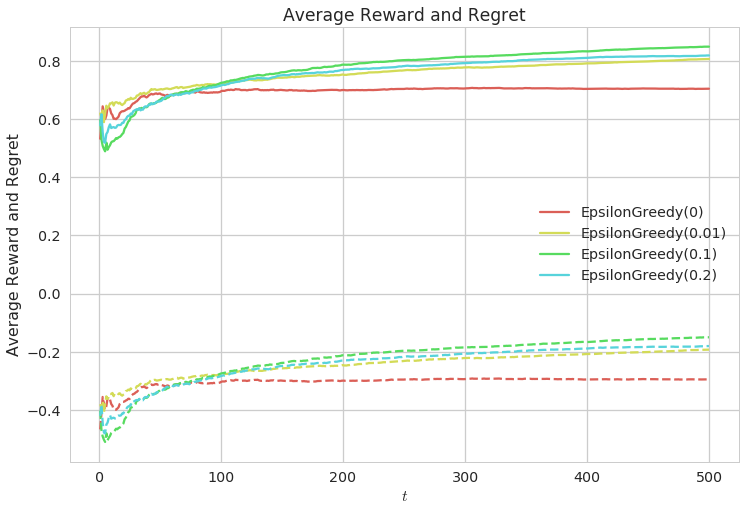

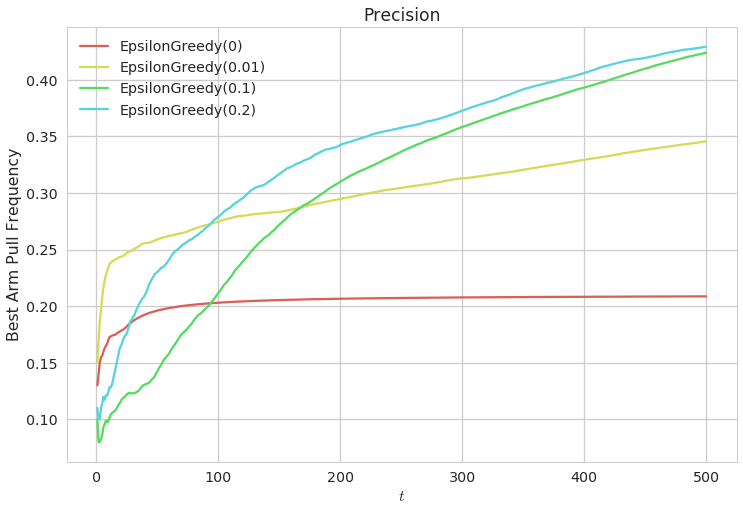

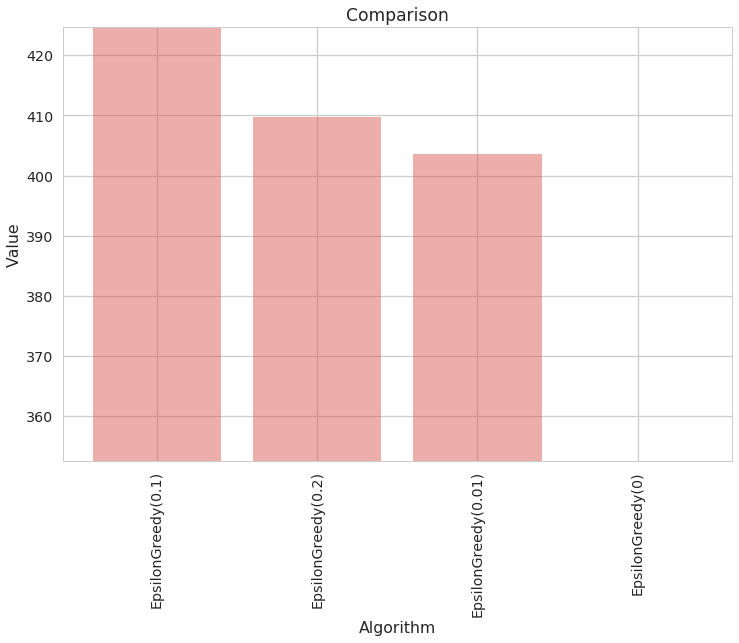

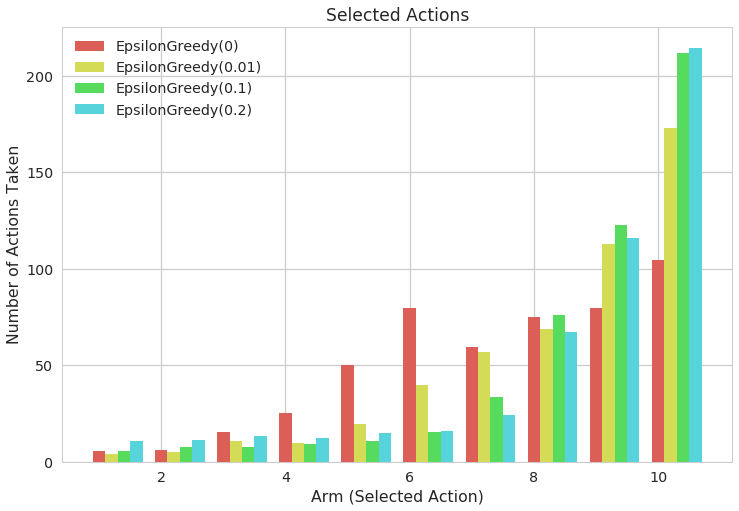

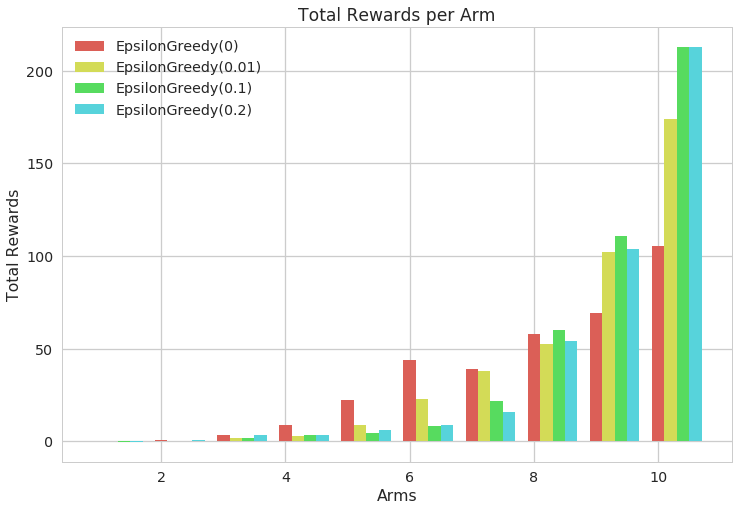

In [9]:
#Run experiments
M = mabs(A, G, tau, repetitions=m)
M.run(tqdm_leave=True)

#Plot Results
M.plot_cumulated_reward_regret_progression()
M.plot_average_reward_regret_progression()
M.plot_precision_progression()
M.plot_comp_algs()
M.plot_comp_arm_count()
M.plot_comp_arm_rewards()

Viewing the average selection of the algorithms, we see why the larger ϵ value performs well, it takes the optimal selection 80% of the time.
Play around with the different values of both ϵ and k to see how these results change. For example, decreasing the search space would likely benefit smaller values of ϵ as exploration would be less beneficial and vice versa. Additionally, increasing the number of iterations will begin to benefit the lower value of ϵ because it will have less random noise.

# ϵ−decay Strategies

The ϵ−greedy
strategies have an obvious weakness in that they continue to include random noise no matter how many examples they see. It would be better for these to settle on an optimal solution and continue to exploit 

$ p = \frac{1}{1 + n / k} $

In [16]:
# ALGORITHMS :

#gamblers
G = [ClassicEpsilonGreedy(k, epsilon=0.1), ClassicEpsilonDecreasing(k)]

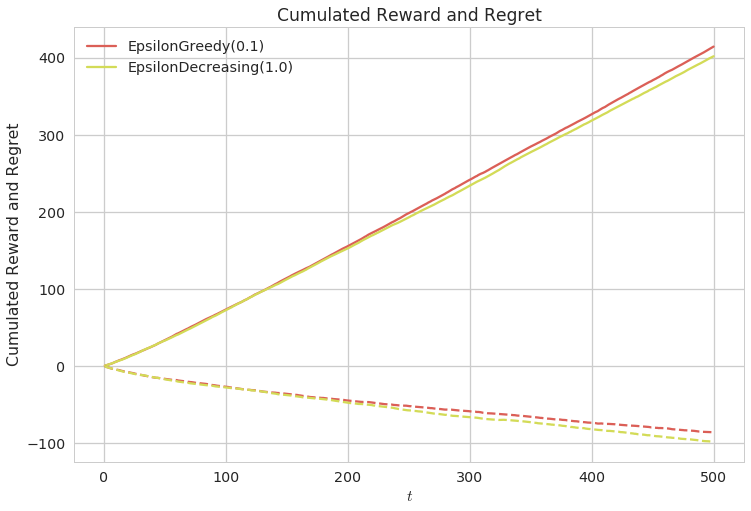

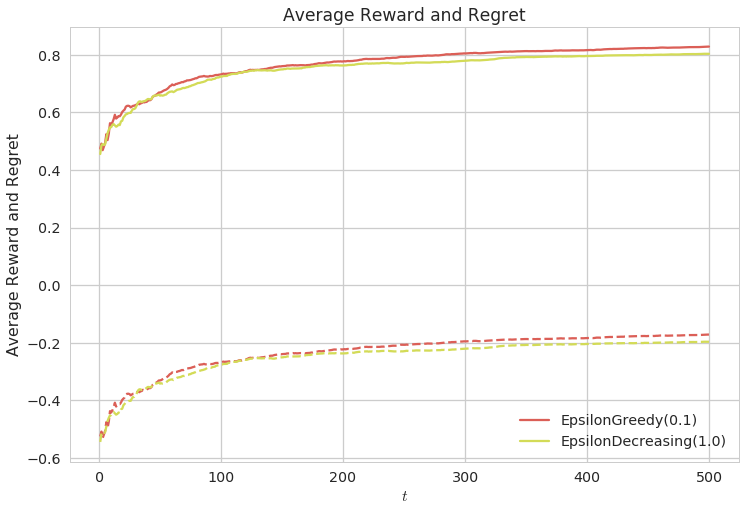

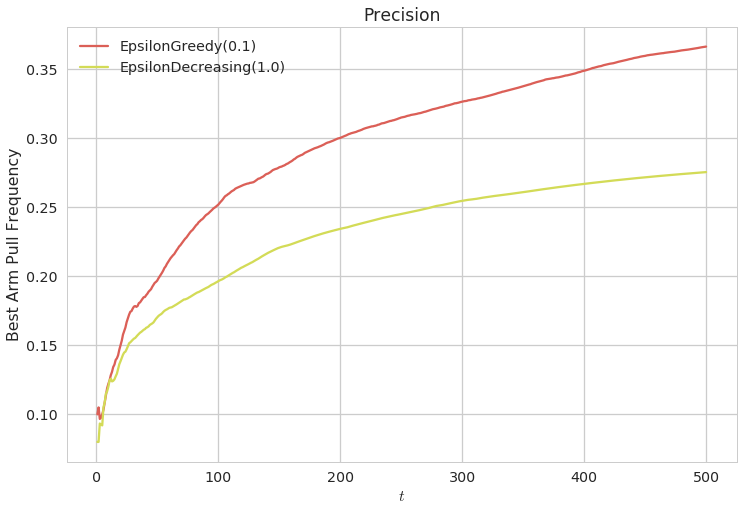

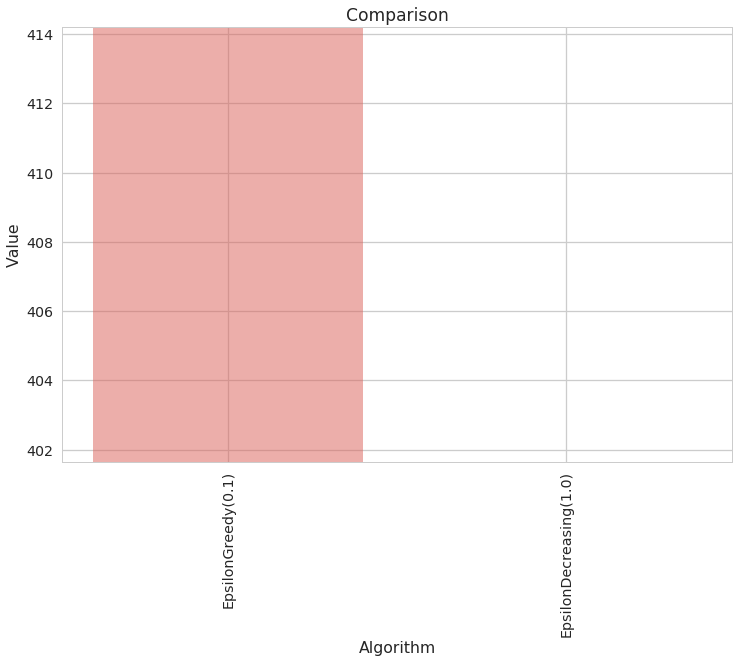

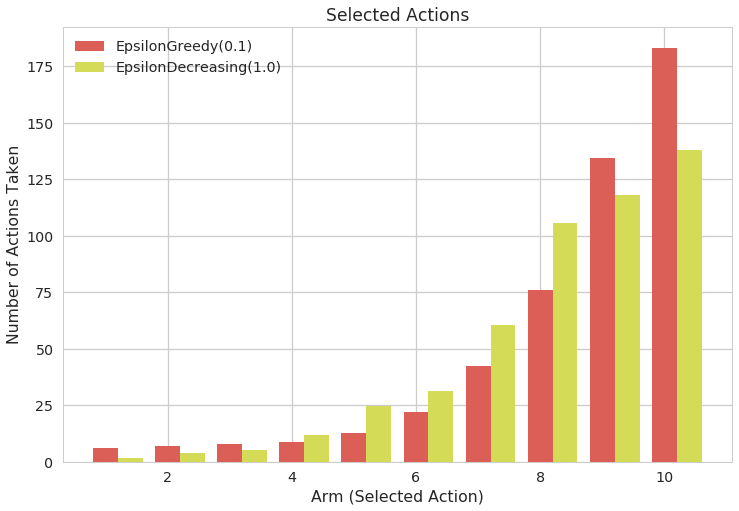

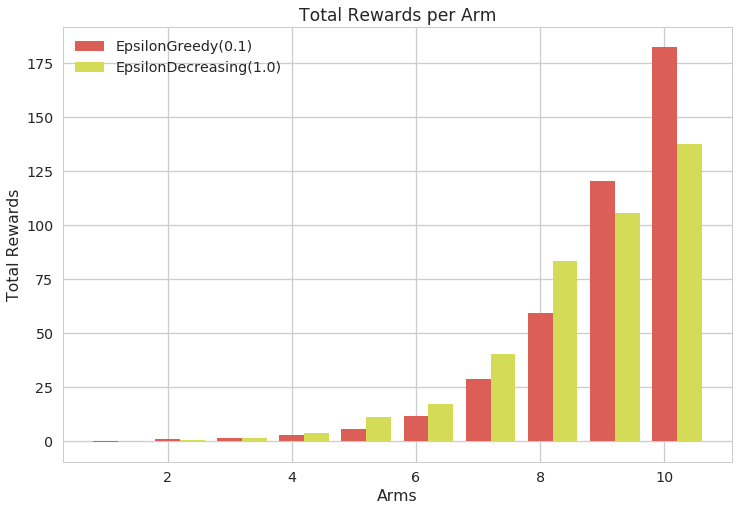

In [17]:
#Run experiments
M = mabs(A, G, tau, repetitions=m)
M.run(tqdm_leave=True)

#Plot Results
M.plot_cumulated_reward_regret_progression()
M.plot_average_reward_regret_progression()
M.plot_precision_progression()
M.plot_comp_algs()
M.plot_comp_arm_count()
M.plot_comp_arm_rewards()

The ϵ−decay strategy outperforms our previous best algorithm as it sticks to the optimal action once it is found.
There's one last method to balance the explore-exploit dilemma in k-bandit problems, optimistic initial values.

## Optimistic Initial Values

This approach differs significantly from the previous examples we explored because it does not introduce random noise to find the best action, A∗n. 
Instead, we overestimate the rewards of all the actions and continuously select the maximium. In this case, the algorithm explores early on as it seeks to maximize its returns while additional information allows the values to converge to their true means. This approach does require some additional background knowledge to be included in the set up because we need at least some idea of what the r

In [32]:
# ALGORITHMS :

#gamblers
G = [ClassicEpsilonGreedy(k, epsilon=0.1), ClassicEpsilonDecreasing(k), ClassicOptimisticGreedy(k, init_estimation=10.0), ClassicOptimisticGreedy(k, init_estimation=1.0)]

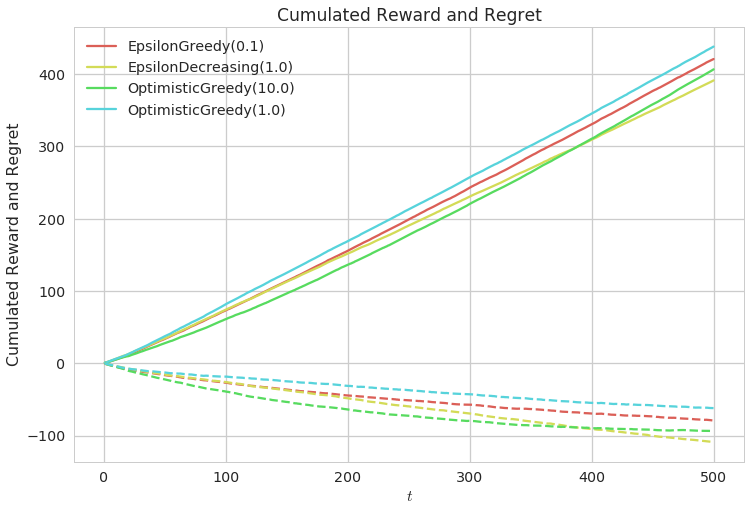

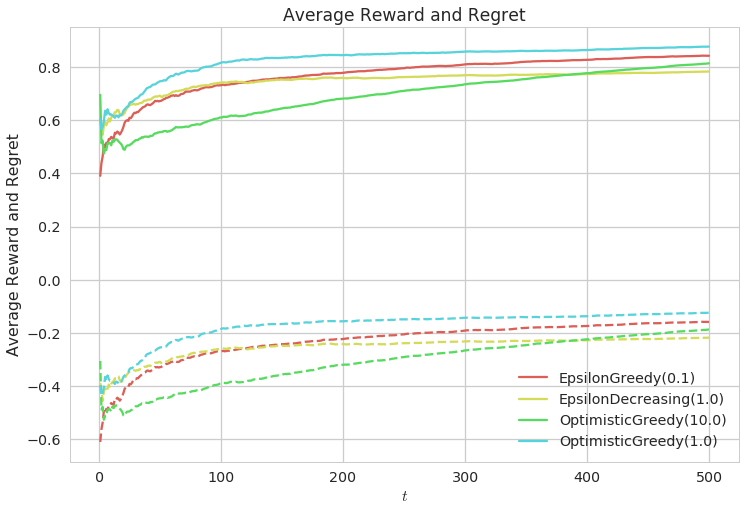

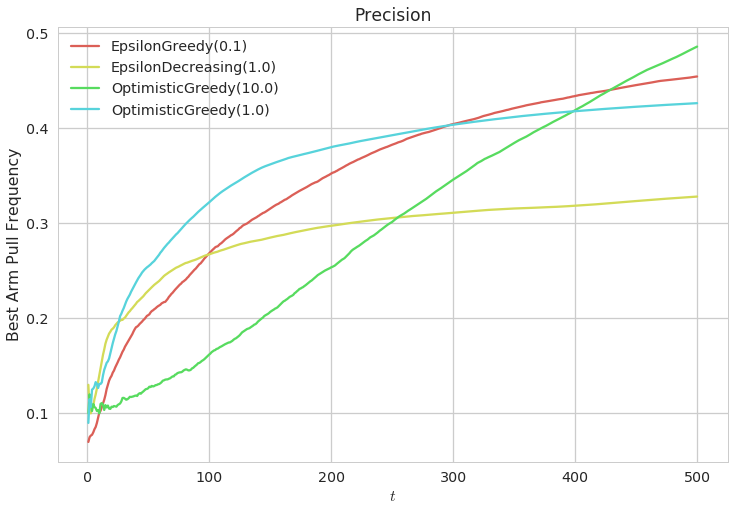

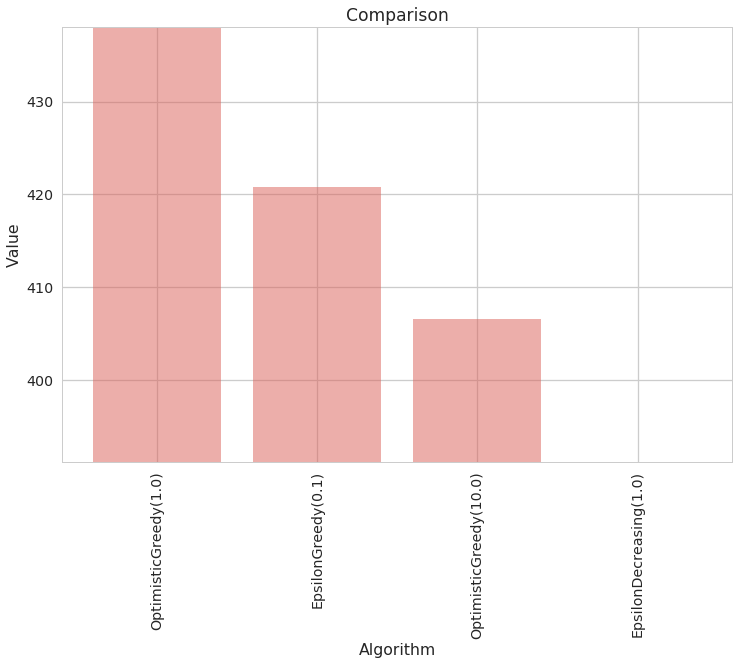

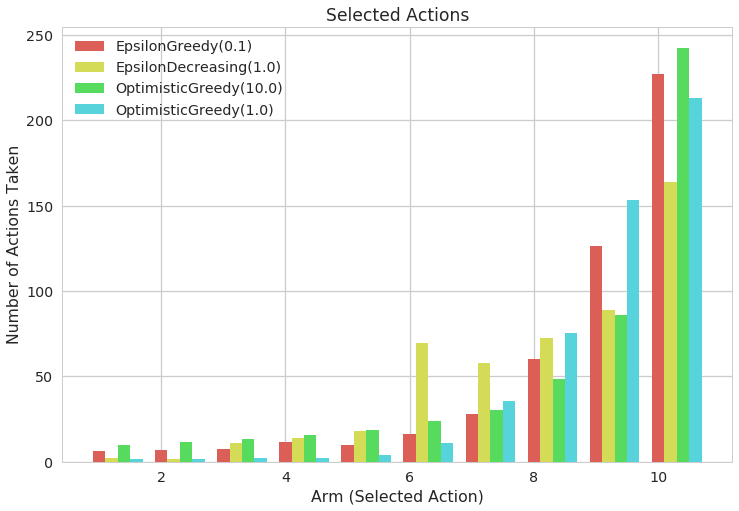

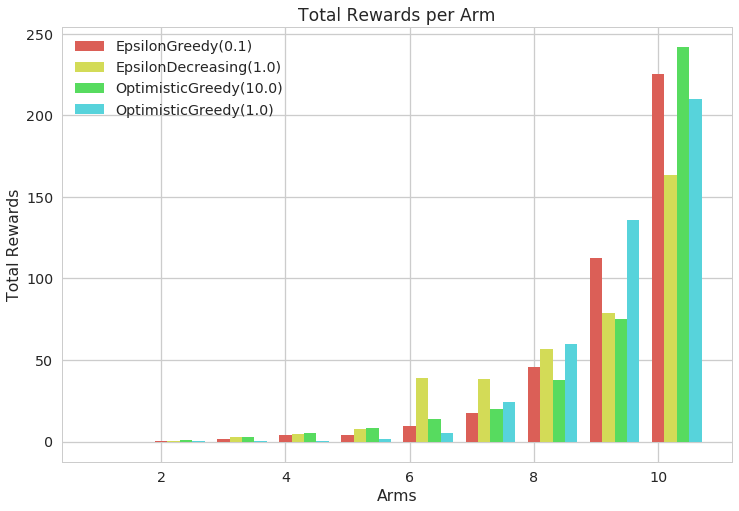

In [33]:
#Run experiments
M = mabs(A, G, tau, repetitions=m)
M.run(tqdm_leave=True)

#Plot Results
M.plot_cumulated_reward_regret_progression()
M.plot_average_reward_regret_progression()
M.plot_precision_progression()
M.plot_comp_algs()
M.plot_comp_arm_count()
M.plot_comp_arm_rewards()

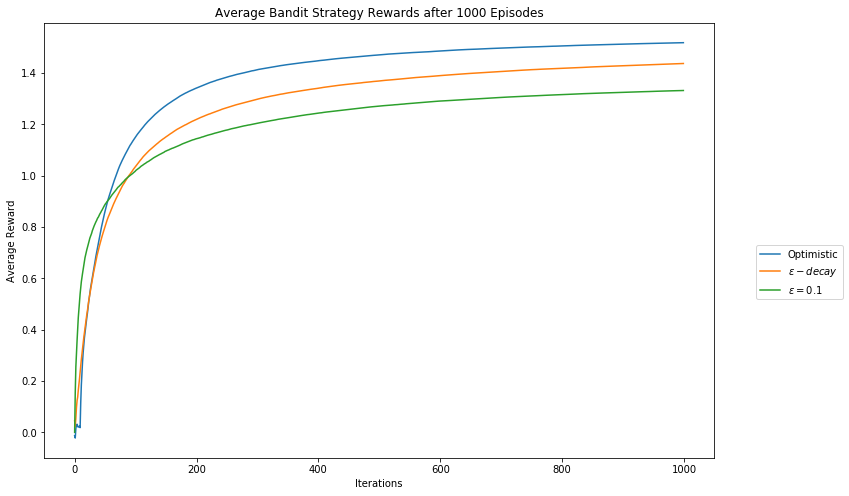

In [8]:
k = 10
iters = 1000

oiv_rewards = np.zeros(iters)
eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

# Select initial values
oiv_init = np.repeat(5., k)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    oiv_bandit = eps_bandit(k, 0, iters)
    oiv_bandit.k_reward = oiv_init.copy()
    oiv_bandit.k_n = np.ones(k)
    eps_decay = eps_decay_bandit(k, iters, oiv_bandit.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, oiv_bandit.mu.copy())
    
    # Run experiments
    oiv_bandit.run()
    eps_decay.run()
    eps_1.run()
    
    # Update long-term averages
    oiv_rewards = oiv_rewards + (
        oiv_bandit.reward - oiv_rewards) / (i + 1)
    eps_decay_rewards = eps_decay_rewards + (
        eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(oiv_rewards, label="Optimistic")
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Bandit Strategy Rewards after " + str(episodes) + " Episodes")
plt.show()

We can see that, in this case, the optimistic initial value approach outperformed both our ϵ−greedy and the ϵ−decay algorithms. We can see too, the estimates the algorithm has for each of arms in the last episode.

In [9]:
df = pd.DataFrame({"number of selections": oiv_bandit.k_n - 1,
                  "actual reward": oiv_bandit.mu,
                  "estimated reward": oiv_bandit.k_reward})
df

The estimates are far off the actual rewards in all cases except the one with 961 pulls. This highlights a lot of what we'll be doing in reinforcement learning more generally. We don't necessarily care about acquiring accurate representations of the environment we are interacting with. Instead, we intend to learn optimal behavior in those situations and seek to behave accordingly. This can open up a whole discussion about model-free versus model-based learning that we'll have to postpone for another time.
There are other bandit methods that we will explore such as the gradient bandits, upper confidence bound (UCB) methods, and nonstationary problems. Plus, many others like dueling bandits, cluster bandits, collaborative filtering bandits, spatially correlated bandits, distributed bandtis, adversarial bandits, and contextual bandits which are open to exploration. Starting to wonder if we haven't been hit with intellectual sabotage...

\section{First section}
\textbf{Hello}
\begin{equation} 
c = \sqrt{a^2 + b^2}
\end{equation}
\begin{itemize}
\item First item
\item Second item
\end{itemize}
\textit{Great!}